### Setup inicial e preparação dos dados

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('OK')

years = ['2009', '2019']

def create_paths_for_many_years(years, file_base_name):
    paths = dict()
    for year in years:
        paths[year] = '{}/dados/{}.CSV'.format(year, file_base_name)
    return paths
    
def read_datasets_for_many_years(years, paths):
    dfs = dict()
    for year in years:
        dfs[year] = pd.read_csv(filepath_or_buffer=paths[year], sep='|', engine='python', encoding=encoding)
    return dfs

teacher_paths = create_paths_for_many_years(years, 'SUP_DOCENTE')   

encoding='ISO-8859-1'

def get_federals(df):
    public  = df[df["TP_CATEGORIA_ADMINISTRATIVA"].isin([1])]
    return public

teachers = read_datasets_for_many_years(years, teacher_paths)
columns = ['CO_CATEGORIA_ADMINISTRATIVA', 'CO_SITUACAO_DOCENTE', 'CO_ESCOLARIDADE_DOCENTE', 'IN_SEXO_DOCENTE', 'CO_COR_RACA_DOCENTE', 'IN_DOCENTE_DEFICIENCIA', 'IN_BOLSA_PESQUISA', 'IN_SUBSTITUTO']
teachers['2009'] = teachers['2009'][columns]

### 2009 adjusts
columns = {
    'CO_CATEGORIA_ADMINISTRATIVA': 'TP_CATEGORIA_ADMINISTRATIVA', 
    'CO_SITUACAO_DOCENTE': 'TP_SITUACAO',
    'CO_ESCOLARIDADE_DOCENTE': 'TP_ESCOLARIDADE',
    'IN_SEXO_DOCENTE': 'TP_SEXO',
    'CO_COR_RACA_DOCENTE': 'TP_COR_RACA',
    'IN_DOCENTE_DEFICIENCIA': 'IN_DEFICIENCIA'
}
teachers['2009'].rename(columns=columns, inplace=True)
teachers['2009']['NU_ANO_CENSO'] = pd.Series([2009 for x in range(len(teachers['2009'].index))])

teachers['2009']['TP_CATEGORIA_ADMINISTRATIVA'] = teachers['2009']['TP_CATEGORIA_ADMINISTRATIVA'].replace({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada', 5: 'Privada', 6: 'Privada'})
teachers['2009']['TP_SEXO'] = teachers['2009']['TP_SEXO'].replace({0: 'Masculino', 1: 'Feminino'})

teachers['2009'].head()

### 2019 adjusts
columns = ['NU_ANO_CENSO', 'TP_CATEGORIA_ADMINISTRATIVA', 'TP_SITUACAO', 'TP_ESCOLARIDADE', 'TP_SEXO', 'TP_COR_RACA', 'IN_DEFICIENCIA', 'IN_BOLSA_PESQUISA', 'IN_SUBSTITUTO']
teachers['2019'] = teachers['2019'][columns]
teachers['2019']['TP_CATEGORIA_ADMINISTRATIVA'] = teachers['2019']['TP_CATEGORIA_ADMINISTRATIVA'].replace({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada', 5: 'Privada', 6: 'Privada', 7: 'Especial', 8: 'Privada', 9: 'Privada'})
teachers['2019']['TP_SEXO'] = teachers['2019']['TP_SEXO'].replace({1: 'Feminino', 2: 'Masculino'})

### multiple adjusts
df = pd.concat([teachers['2009'], teachers['2019']])
df['TP_SITUACAO'] = df['TP_SITUACAO'].replace({1: 'Em exercício', 2: 'Afastado para qualificação', 3: 'Afastado por outros motivos', 4: 'Afastado por outros motivos', 5: 'Afastado por outros motivos', 6: 'Falecido'})
df['TP_ESCOLARIDADE'] = df['TP_ESCOLARIDADE'].replace({1: 'Sem graduação', 2: 'Graduação', 3: 'Especialização', 4: 'Mestrado', 5: 'Doutorado'})
df['TP_COR_RACA'] = df['TP_COR_RACA'].replace({0: 'Não quis declarar', 1: 'Branca', 2: 'Preta', 3: 'Parda', 4: 'Amarela', 5: 'Indígena', 6: 'Não dispõe da informação', 9: 'Não dispõe da informação'})
df['IN_DEFICIENCIA'] = df['IN_DEFICIENCIA'].replace({0: False, 1: True, 9: None})
df['IN_BOLSA_PESQUISA'] = df['IN_BOLSA_PESQUISA'].replace({0: False, 1: True})
df['IN_SUBSTITUTO'] = df['IN_SUBSTITUTO'].replace({0: False, 1: True})

df.rename(columns={'TP_CATEGORIA_ADMINISTRATIVA': 'Categoria Administrativa', 'TP_SITUACAO': 'Situação', 'TP_ESCOLARIDADE': 'Escolaridade', 'TP_SEXO': 'Sexo', 'TP_COR_RACA': 'Raça', 'NU_ANO_CENSO': 'Ano', 'IN_DEFICIENCIA': 'Deficiência', 'IN_BOLSA_PESQUISA': 'Bolsa Pesquisa', 'IN_SUBSTITUTO': 'Substituto'}, inplace=True)

def get_total_by_year_by_reference(total_by_year, total_references, x):
    if len(total_references) <= 0:
        return total_by_year[x['Ano']]
    else:
        return total_by_year[tuple(x[col] for col in (['Ano']+total_references))]

def create_table_by_segregators(input_df, segregators, total_references = []):
    count_by_segregators_and_year = input_df.groupby(['Ano'] + segregators).size().reset_index(name='Quantidade')
    total_by_year = count_by_segregators_and_year.groupby(['Ano'] + total_references)['Quantidade'].sum()
    count_by_segregators_and_year['Porcentagem'] = count_by_segregators_and_year.apply(lambda x: (x['Quantidade'] / get_total_by_year_by_reference(total_by_year, total_references, x) * 100).round(2), axis=1)

    percentage_pivot = count_by_segregators_and_year.pivot(index=segregators, columns='Ano', values='Porcentagem')
    quantity_pivot  = count_by_segregators_and_year.pivot(index=segregators, columns='Ano', values='Quantidade')
    entities_by_segregators = pd.concat([quantity_pivot, percentage_pivot], axis=1)

    columns_tuples = [
        ('Quantidade', entities_by_segregators.columns[0]),
        ('Quantidade', entities_by_segregators.columns[1]),
        ('Porcentagem', entities_by_segregators.columns[2]),
        ('Porcentagem', entities_by_segregators.columns[3])
    ]
    columns = pd.MultiIndex.from_tuples(columns_tuples)
    entities_by_segregators.columns = columns

    quantity_evolution = entities_by_segregators['Quantidade', 2019] - entities_by_segregators['Quantidade', 2009]
    percentage_evolution = entities_by_segregators['Porcentagem', 2019] - entities_by_segregators['Porcentagem', 2009]
    
    percentage_increase = ((percentage_evolution/entities_by_segregators['Porcentagem', 2009]) * 100).round(2)

    entities_by_segregators[('Quantidade', 'Evolução')] = quantity_evolution
    entities_by_segregators[('Porcentagem', 'Evolução (%)')] = percentage_evolution
    entities_by_segregators[('Porcentagem', 'Aumento Percentual (%)')] = percentage_increase

    new_columns_order = [
        ('Quantidade', 2009),
        ('Quantidade', 2019),
        ('Quantidade', 'Evolução'),
        ('Porcentagem', 2009),
        ('Porcentagem', 2019),
        ('Porcentagem', 'Evolução (%)'),
        ('Porcentagem', 'Aumento Percentual (%)')
    ]

    entities_by_segregators = entities_by_segregators[new_columns_order]
    entities_by_segregators.index.name = segregators[0]

    reseted_entities_by_segregators = entities_by_segregators.reset_index()

    segregators_dict = dict()
    for segregator in segregators:
        segregators_dict[segregator] = reseted_entities_by_segregators[segregator]

    segregators_dict[2009] = reseted_entities_by_segregators[('Porcentagem', 2009)]
    segregators_dict[2019] = reseted_entities_by_segregators[('Porcentagem', 2019)]
    segregators_dict['Evolução (%)'] = reseted_entities_by_segregators[('Porcentagem', 'Evolução (%)')]
    segregators_dict['Aumento Percentual (%)'] = reseted_entities_by_segregators[('Porcentagem', 'Aumento Percentual (%)')]

    entities_evolution_by_segregators = pd.DataFrame(segregators_dict)

    return entities_by_segregators, entities_evolution_by_segregators, count_by_segregators_and_year

def plot_slope_graph(x, y, hue, data, **kwargs):
    ax = kwargs.get('ax', None)
    if not ax:
        fig, ax = plt.subplots()
    
    graph = sns.lineplot(x=x, y=y, hue=hue, marker='o', linewidth=2, data=data, **kwargs)
    graph.set_xticks([2009, 2019])
    #ax.set_title("Relação entre total da conta e gorjeta")

    for line, name in zip(graph.lines, data[hue].unique()):
        if len(line.get_ydata()):
            y_initial = line.get_ydata()[0]
            y_final = line.get_ydata()[-1]

            # Adicionar valor inicial
            graph.annotate(f'{y_initial:.2f}%',
                           xy=(0, y_initial),
                           xytext=(-37, 0),
                           color=line.get_color(),
                           xycoords=graph.get_yaxis_transform(),
                           textcoords="offset points",
                           size=10,
                           va="center")

            # Adicionar valor final
            graph.annotate(f'{y_final:.2f}%     {name}',
                           xy=(1, y_final),
                           xytext=(0, 0),
                           color=line.get_color(),
                           xycoords=graph.get_yaxis_transform(),
                           textcoords="offset points",
                           size=10,
                           va="center")   


    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    graph.legend_ = None
      
        
def plot_comparison_graph(count_by_segregator_and_year_df, segregator, spacing = 0.5, label_rotation = 0, horizontalalignment = 'center', **kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(wspace=spacing, hspace=spacing)
    
    graphs = []

    graphs.append(sns.barplot(x=segregator, y="Quantidade", hue="Ano", data=count_by_segregator_and_year_df, ax=axs[0, 0], **kwargs))
    graphs.append(sns.barplot(x=segregator, y="Porcentagem", hue="Ano", data=count_by_segregator_and_year_df, ax=axs[0,1], **kwargs))

    graphs.append(sns.lineplot(x="Ano", y="Quantidade", hue=segregator, marker='o', data=count_by_segregator_and_year_df, ax=axs[1,0]))
    graphs.append(sns.lineplot(x="Ano", y="Porcentagem", hue=segregator, marker='o', data=count_by_segregator_and_year_df, ax=axs[1,1]))

    for graph in graphs[2:4]:
        graph.set_xticks([2009, 2019])

    for graph in graphs:
        graph.set_xticklabels(graph.get_xticklabels(), rotation=label_rotation, horizontalalignment=horizontalalignment)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    return count_by_segregator_and_year_df


def plot_evolution_graph(entities_evolution_by_segregator, segregator, spacing = 0.5, label_rotation = 0, horizontalalignment = 'center', **kwargs):
    fig, axs = plt.subplots()
    graph = sns.barplot(x=segregator, y='Aumento Percentual (%)', data=entities_evolution_by_segregator, **kwargs)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=label_rotation, horizontalalignment=horizontalalignment)
    plt.tight_layout()

OK


In [50]:
df.head()

,Categoria Administrativa,Situação,Escolaridade,Sexo,Raça,Deficiência,Bolsa Pesquisa,Substituto,Ano
0,Federal,Em exercício,Especialização,Masculino,Branca,False,False,False,2009
1,Federal,Em exercício,Doutorado,Feminino,Branca,False,False,False,2009
2,Federal,Em exercício,Mestrado,Feminino,Branca,False,False,False,2009
3,Federal,Em exercício,Mestrado,Masculino,Não dispõe da informação,False,False,False,2009
4,Federal,Em exercício,Mestrado,Masculino,Não quis declarar,False,False,False,2009


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758517 entries, 0 to 399427
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Categoria Administrativa  758517 non-null  object
 1   Situação                  758517 non-null  object
 2   Escolaridade              758517 non-null  object
 3   Sexo                      758517 non-null  object
 4   Raça                      758517 non-null  object
 5   Deficiência               715141 non-null  object
 6   Bolsa Pesquisa            470661 non-null  object
 7   Substituto                734072 non-null  object
 8   Ano                       758517 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 57.9+ MB


In [53]:
df.isna().sum()

Categoria Administrativa         0
Situação                         0
Escolaridade                     0
Sexo                             0
Raça                             0
Deficiência                  43376
Bolsa Pesquisa              287856
Substituto                   24445
Ano                              0
dtype: int64

In [11]:
analysis_df = df[(df['Situação'] == 'Em exercício') & (df['Raça'] != 'Não dispõe da informação') & (df['Raça'] != 'Não quis declarar')]

## Qual a presença de docentes por raça?

In [12]:
teachers_by_race, teachers_evolution_by_race, count_by_race_and_year = create_table_by_segregators(analysis_df, segregators=['Raça'])
total_by_year = analysis_df.groupby('Ano').size().reset_index(name='Quantidade').set_index('Ano').reset_index()
total_by_year

,Ano,Quantidade
0,2009,206197
1,2019,272985


In [13]:
teachers_by_race

Quantidade                  Porcentagem                      \
               2009    2019 Evolução        2009   2019 Evolução (%)   
Raça                                                                   
Amarela        2607    3941     1334        1.26   1.44         0.18   
Branca       166797  204072    37275       80.89  74.76        -6.13   
Indígena        443     494       51        0.21   0.18        -0.03   
Parda         32293   56662    24369       15.66  20.76         5.10   
Preta          4057    7816     3759        1.97   2.86         0.89   

                                 
         Aumento Percentual (%)  
Raça                             
Amarela                   14.29  
Branca                    -7.58  
Indígena                 -14.29  
Parda                     32.57  
Preta                     45.18

In [14]:
teachers_evolution_by_race

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.26,1.44,0.18,14.29
1,Branca,80.89,74.76,-6.13,-7.58
2,Indígena,0.21,0.18,-0.03,-14.29
3,Parda,15.66,20.76,5.10,32.57
4,Preta,1.97,2.86,0.89,45.18


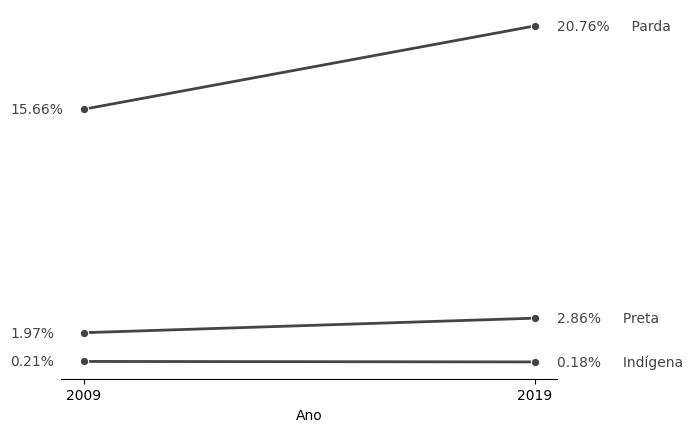

In [15]:
palette = {'Preta': '#444', 'Parda': '#444', 'Indígena': '#444'}    
desired_races_df = count_by_race_and_year[count_by_race_and_year['Raça'].isin(['Preta', 'Parda', 'Indígena'])]
plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", data=desired_races_df, palette=palette)

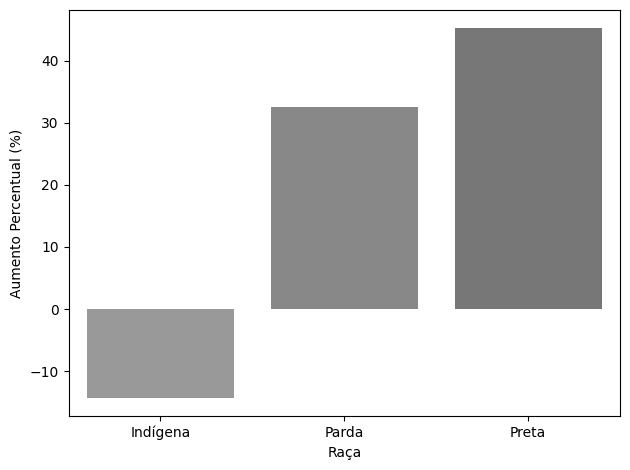

In [16]:
palette = {'Preta': '#777', 'Parda': '#888', 'Indígena': '#999'} 
plot_evolution_graph(teachers_evolution_by_race[teachers_evolution_by_race['Raça'].isin(['Preta', 'Parda', 'Indígena'])], 'Raça', palette=palette)  

## Qual a presença de docentes por escolaridade?

In [57]:
teachers_by_race_and_scolarship, teachers_evolution_by_race_and_scolarship, count_by_race_and_scolarship_and_year = create_table_by_segregators(analysis_df[(analysis_df['Escolaridade'] != 'Sem graduação')], segregators=['Raça', 'Escolaridade'], total_references=['Raça'])

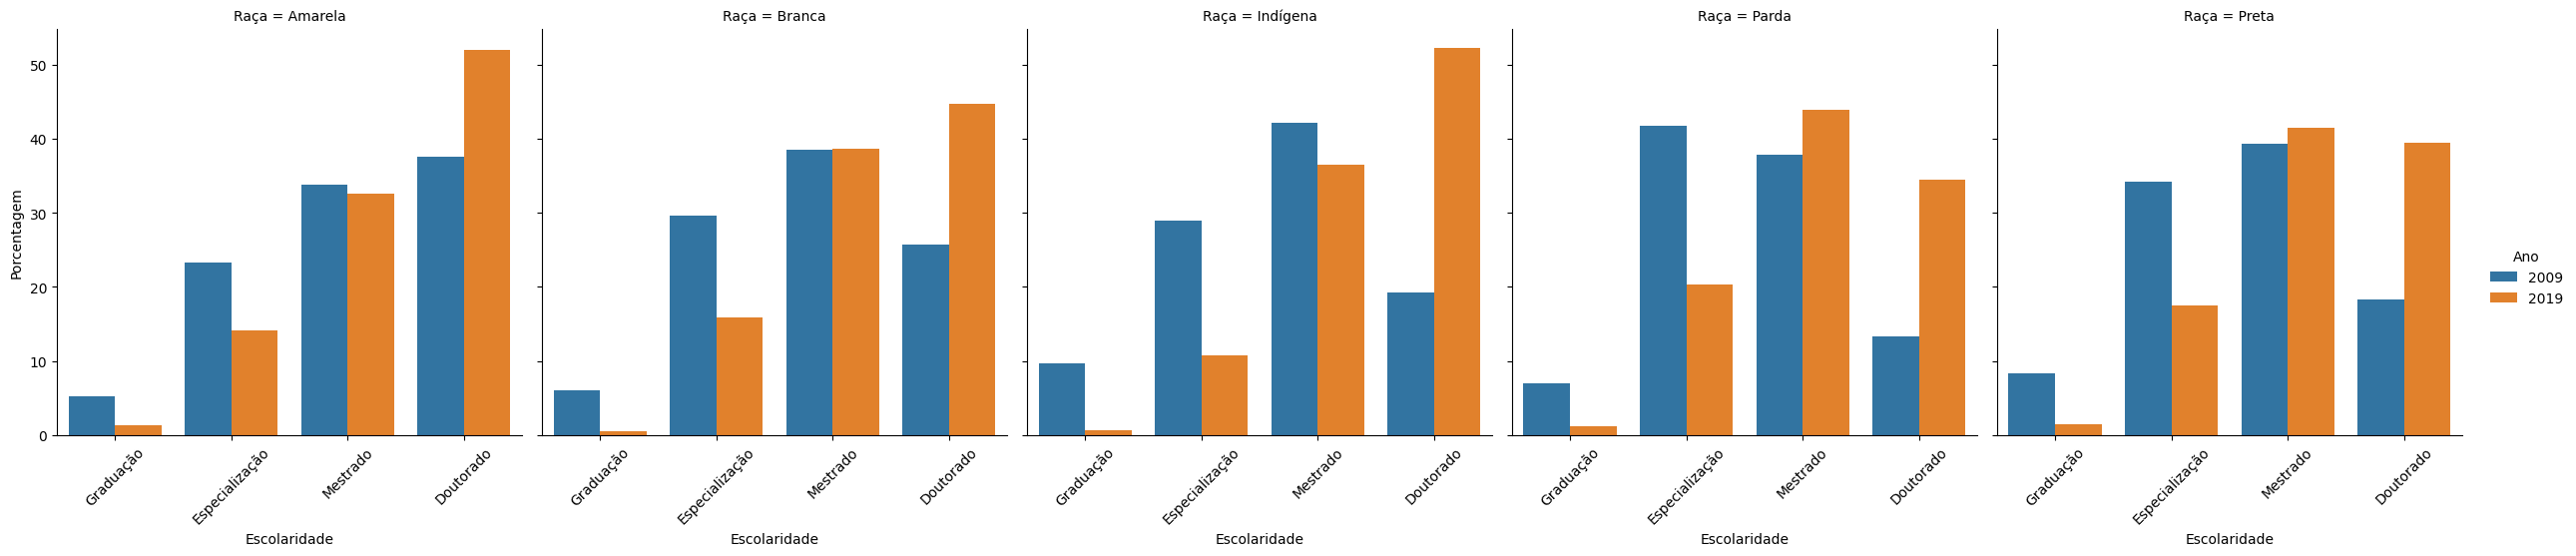

In [58]:
order = ["Graduação", "Especialização", "Mestrado", "Doutorado"]

graph = sns.catplot(
    data=count_by_race_and_scolarship_and_year,
    x='Escolaridade',
    y='Porcentagem',
    hue='Ano',
    col='Raça',
    kind='bar',
    order=order
)

graph.set_xticklabels(rotation=45)

se der tempo vou fazer uma barra horizontal empilhada de 2009 e uma de 2019

- Entre os de raça amarela a predominância em ambos os anos está pendendendo para doutorado, a tendência foi de crescer na carreira
- Entre os de raça Branca a predominância estava centralizada em mestrado, com mais gente na especialização que no doutorado. Isso se inverteu e agora a predominância está em doutorado.
- Entre os indígenas é igual na branca.
- Na parda a predominância era especialização caindo até o doutorado. 

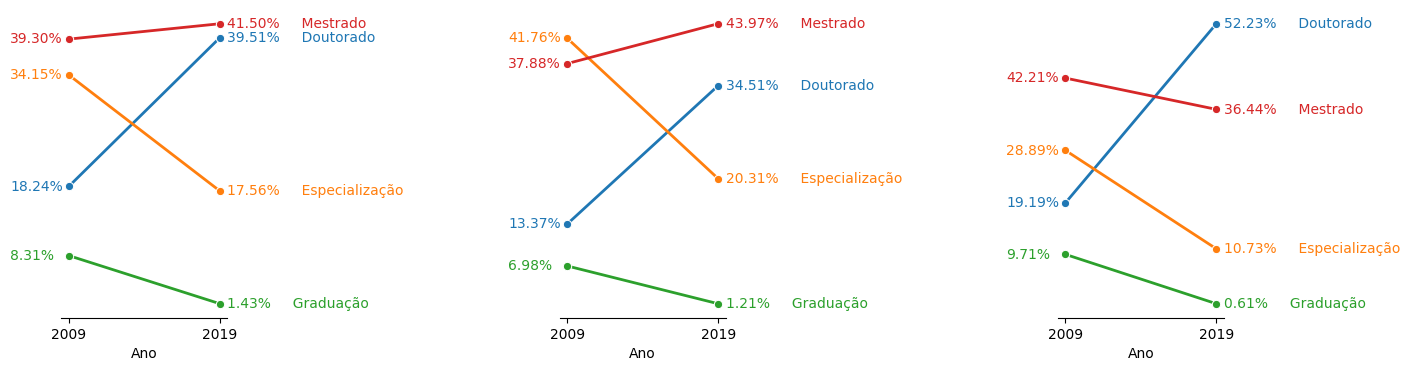

In [59]:
races = ['Preta', 'Parda', 'Indígena']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plt.subplots_adjust(wspace=2)

for i, race in enumerate(races):
    desired_races_df = count_by_race_and_scolarship_and_year[count_by_race_and_scolarship_and_year['Raça'] == race]
    plot_slope_graph(x='Ano', y='Porcentagem', hue='Escolaridade', data=desired_races_df, ax=axes[i])

In [47]:
federal_teachers_by_race_and_scolarship, federal_teachers_evolution_by_race_and_scolarship, count_federal_teachers_by_race_and_scolarship_and_year = create_table_by_segregators(analysis_df[(analysis_df['Escolaridade'] != 'Sem graduação') & (analysis_df['Categoria Administrativa'] == 'Federal')], segregators=['Raça', 'Escolaridade'], total_references=['Raça'])

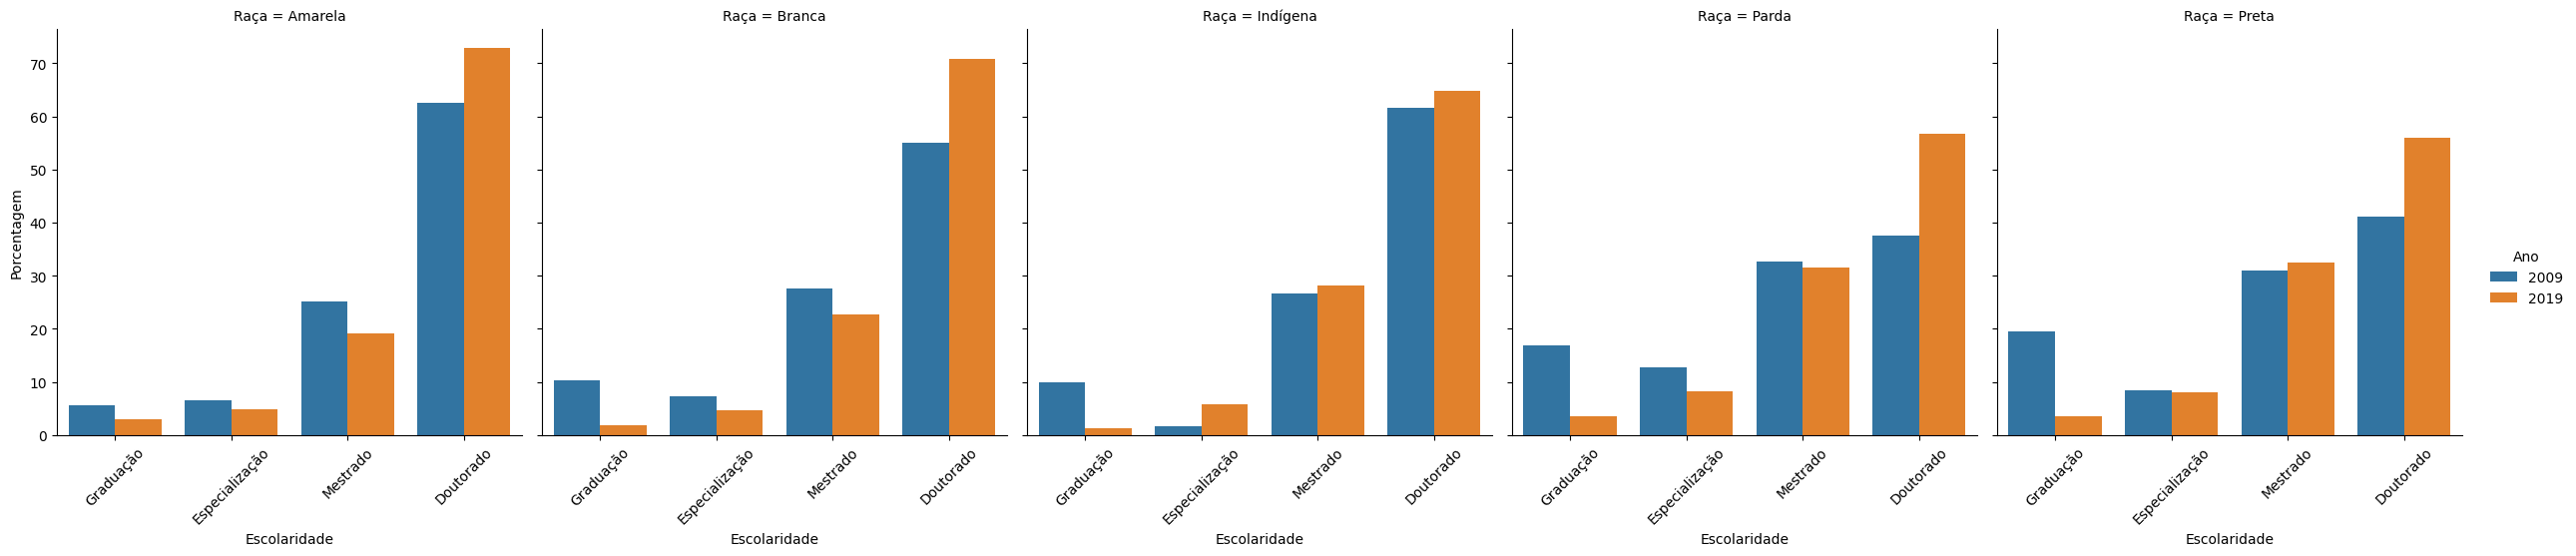

In [26]:
order = ["Graduação", "Especialização", "Mestrado", "Doutorado"]

graph = sns.catplot(
    data=count_federal_teachers_by_race_and_scolarship_and_year,
    x='Escolaridade',
    y='Porcentagem',
    hue='Ano',
    col='Raça',
    kind='bar',
    order=order
)

graph.set_xticklabels(rotation=45)

In [70]:
teachers_by_scolarship_and_race, teachers_evolution_by_scolarship_and_race, count_by_scolarship_and_race_and_year = create_table_by_segregators(analysis_df[(analysis_df['Escolaridade'] != 'Sem graduação') & (analysis_df['Categoria Administrativa'] == 'Federal')], segregators=['Escolaridade', 'Raça'], total_references=['Escolaridade'])

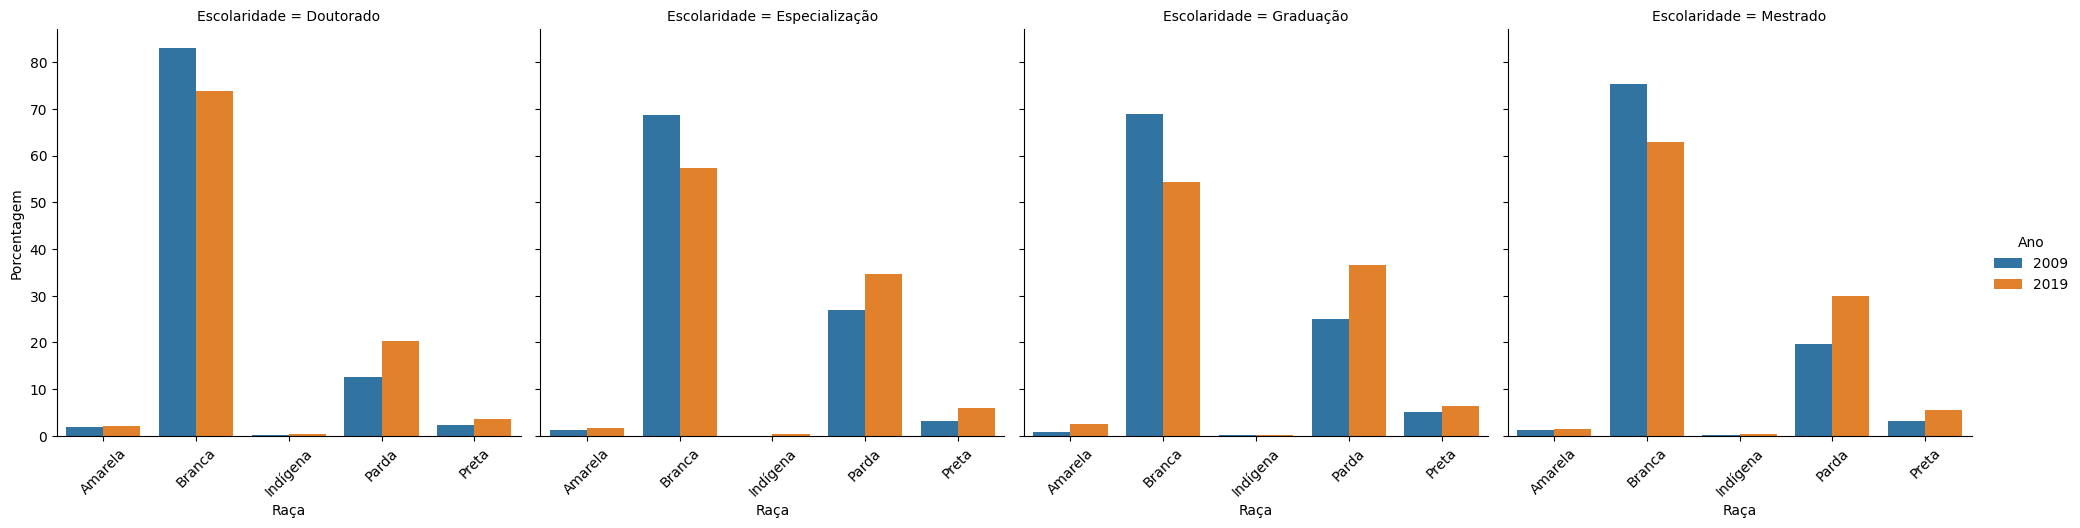

In [71]:

graph = sns.catplot(
    data=count_by_scolarship_and_race_and_year,
    x='Raça',
    y='Porcentagem',
    hue='Ano',
    col='Escolaridade',
    kind='bar',
)

graph.set_xticklabels(rotation=45)

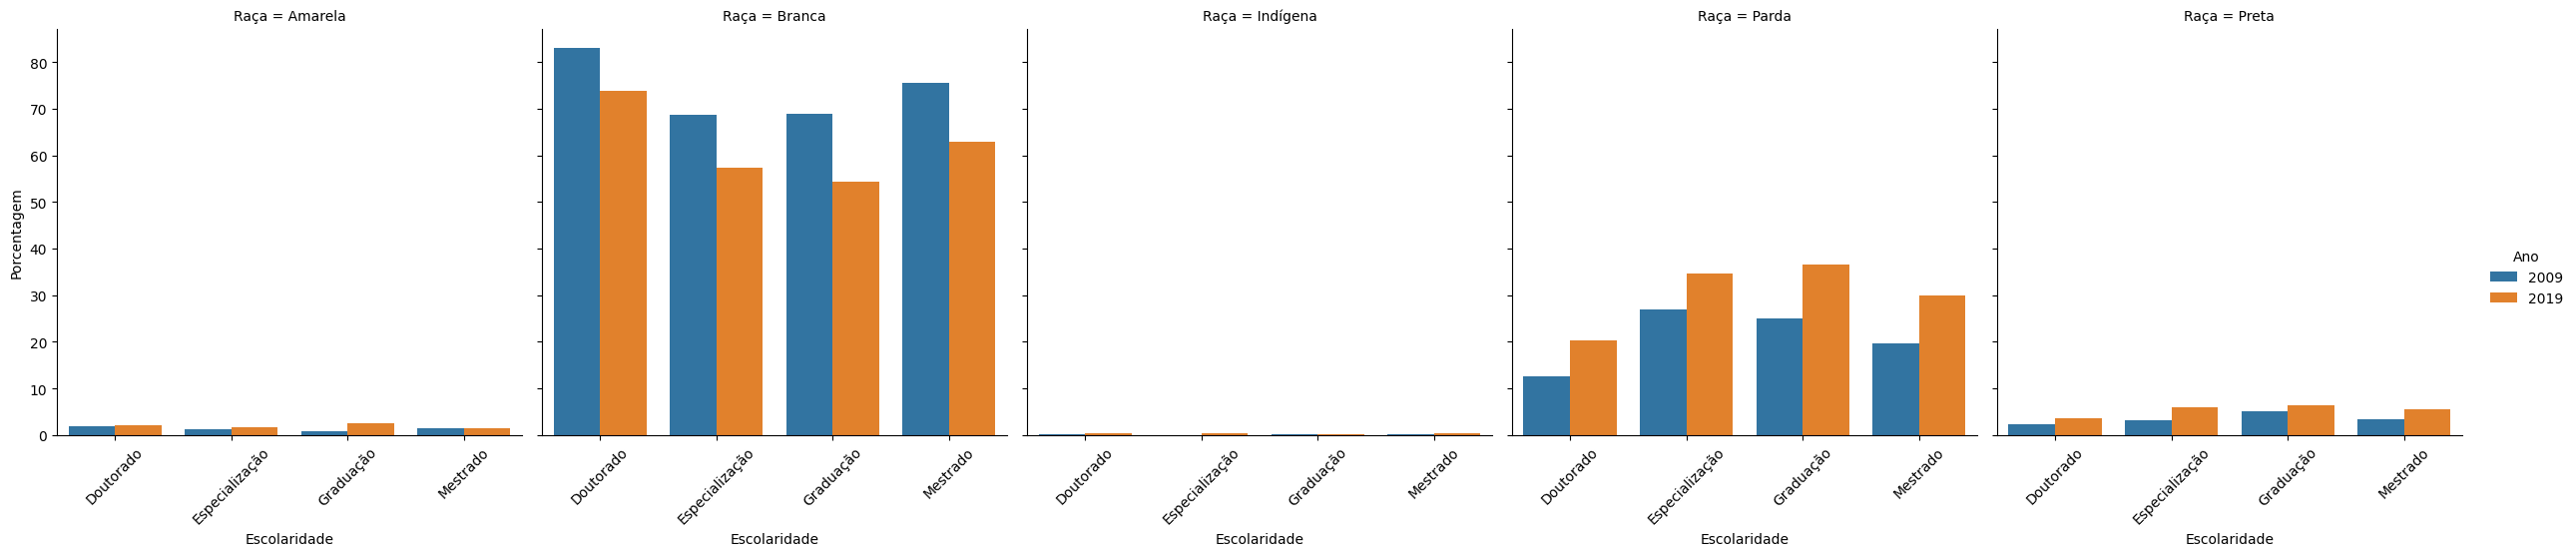

In [73]:
graph = sns.catplot(
    data=count_by_scolarship_and_race_and_year,
    x='Escolaridade',
    y='Porcentagem',
    hue='Ano',
    col='Raça',
    kind='bar',
)

graph.set_xticklabels(rotation=45)

## Qual a presença de docentes por categoria administrativa?

In [27]:
administrative_category_input_df = analysis_df[analysis_df['Categoria Administrativa'] == 'Federal']
teachers_by_administrative_category, teachers_evolution_by_administrative_category, count_by_administrative_category_and_year = create_table_by_segregators(administrative_category_input_df, ['Raça'])

In [28]:
teachers_by_administrative_category

Quantidade                 Porcentagem                      \
               2009   2019 Evolução        2009   2019 Evolução (%)   
Raça                                                                  
Amarela         425   1278      853        1.53   1.88         0.35   
Branca        21634  47283    25649       78.03  69.74        -8.29   
Indígena         60    227      167        0.22   0.33         0.11   
Parda          4768  16156    11388       17.20  23.83         6.63   
Preta           838   2856     2018        3.02   4.21         1.19   

                                 
         Aumento Percentual (%)  
Raça                             
Amarela                   22.88  
Branca                   -10.62  
Indígena                  50.00  
Parda                     38.55  
Preta                     39.40

In [29]:
teachers_evolution_by_administrative_category

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.53,1.88,0.35,22.88
1,Branca,78.03,69.74,-8.29,-10.62
2,Indígena,0.22,0.33,0.11,50.00
3,Parda,17.20,23.83,6.63,38.55
4,Preta,3.02,4.21,1.19,39.40


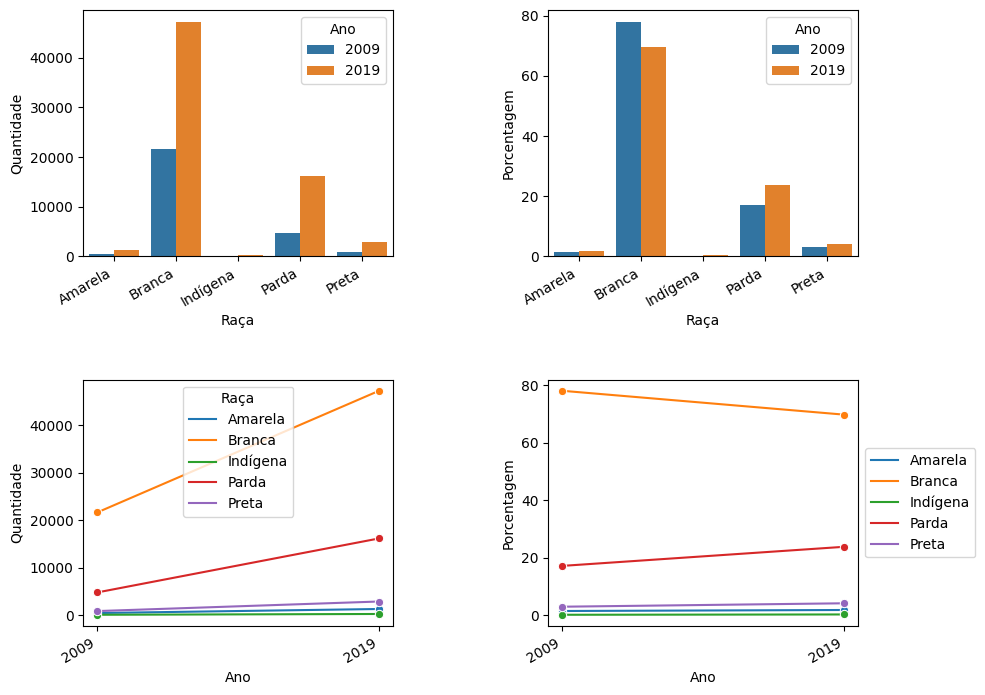

,Ano,Raça,Quantidade,Porcentagem
0,2009,Amarela,425,1.53
1,2009,Branca,21634,78.03
2,2009,Indígena,60,0.22
3,2009,Parda,4768,17.20
4,2009,Preta,838,3.02
5,2019,Amarela,1278,1.88
6,2019,Branca,47283,69.74
7,2019,Indígena,227,0.33
8,2019,Parda,16156,23.83
9,2019,Preta,2856,4.21


In [30]:
plot_comparison_graph(count_by_administrative_category_and_year, segregator='Raça', label_rotation=30, horizontalalignment='right')

## Qual a presença de docentes com bolsa de pesquisa?

In [31]:
teachers_by_research_grant, teachers_evolution_by_research_grant, count_by_research_grant_and_year = create_table_by_segregators(analysis_df[analysis_df['Bolsa Pesquisa'] == True], segregators=['Raça'])

In [32]:
teachers_evolution_by_research_grant

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,2.44,1.63,-0.81,-33.20
1,Branca,88.17,81.47,-6.70,-7.60
2,Indígena,0.12,0.15,0.03,25.00
3,Parda,7.81,14.16,6.35,81.31
4,Preta,1.46,2.59,1.13,77.40


In [33]:
teachers_by_research_grant

Quantidade                Porcentagem                      \
               2009  2019 Evolução        2009   2019 Evolução (%)   
Raça                                                                 
Amarela         184   193        9        2.44   1.63        -0.81   
Branca         6639  9657     3018       88.17  81.47        -6.70   
Indígena          9    18        9        0.12   0.15         0.03   
Parda           588  1679     1091        7.81  14.16         6.35   
Preta           110   307      197        1.46   2.59         1.13   

                                 
         Aumento Percentual (%)  
Raça                             
Amarela                  -33.20  
Branca                    -7.60  
Indígena                  25.00  
Parda                     81.31  
Preta                     77.40

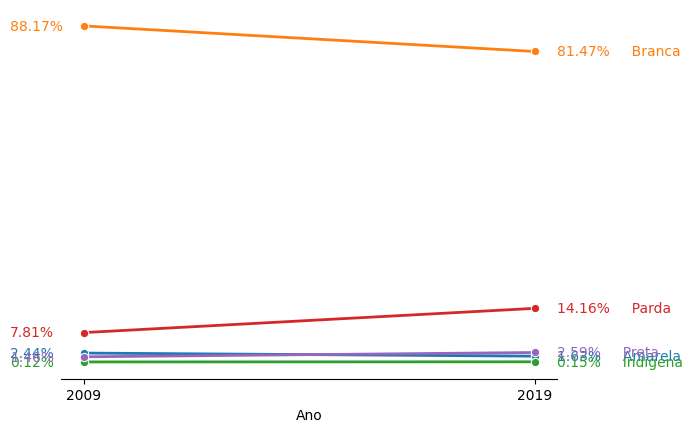

In [34]:
count_by_research_grant_and_year
plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", data=count_by_research_grant_and_year)

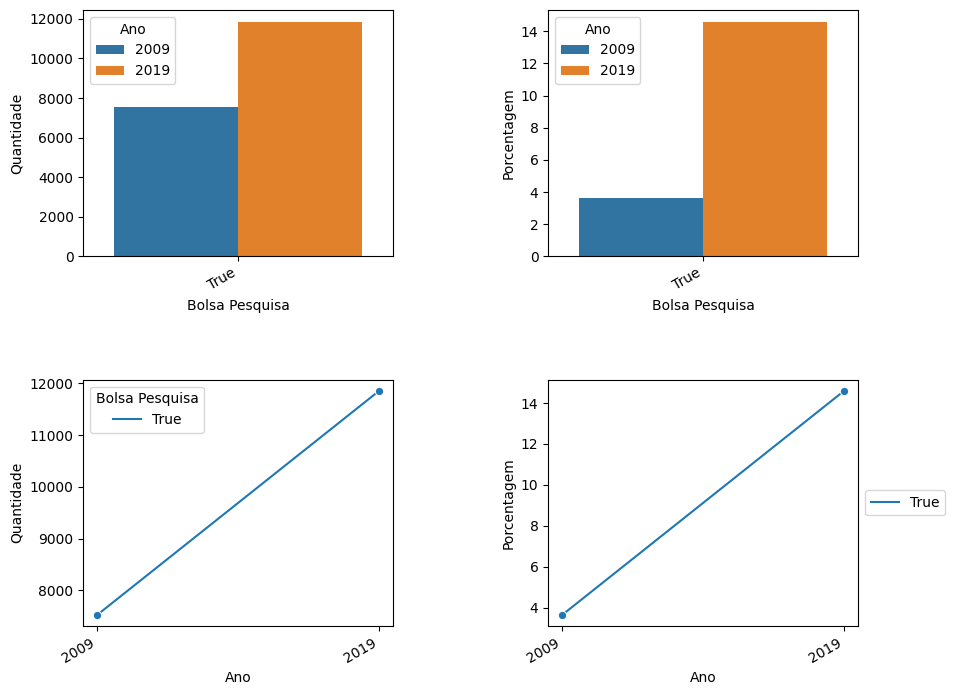

,Ano,Bolsa Pesquisa,Quantidade,Porcentagem
1,2009,True,7530,3.65
3,2019,True,11854,14.60


In [35]:
teachers_by_research_grant, teachers_evolution_by_research_grant, count_by_research_grant_and_year = create_table_by_segregators(analysis_df, segregators=['Bolsa Pesquisa'])
plot_comparison_graph(count_by_research_grant_and_year[(count_by_research_grant_and_year['Bolsa Pesquisa'] == True)], segregator='Bolsa Pesquisa', label_rotation=30, horizontalalignment='right')

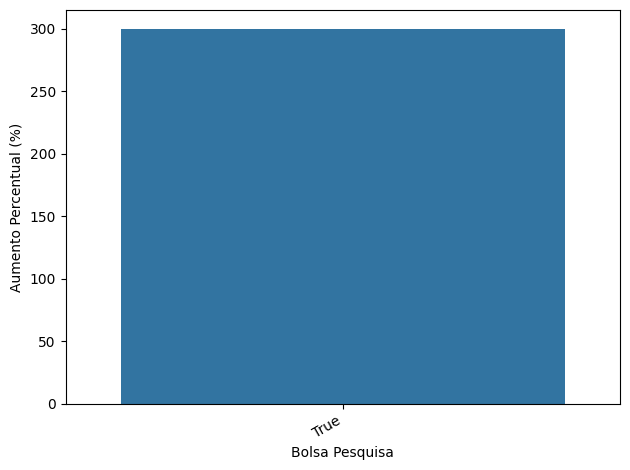

In [36]:
plot_evolution_graph(teachers_evolution_by_research_grant[teachers_evolution_by_research_grant['Bolsa Pesquisa'] == True], 'Bolsa Pesquisa', label_rotation = 30, horizontalalignment='right')

## Qual a presença de docentes deficientes?

In [37]:
teachers_by_deficiency, teachers_evolution_by_deficiency, count_by_deficiency_and_year = create_table_by_segregators(analysis_df[analysis_df['Deficiência'] == True], segregators=['Raça'])

In [38]:
teachers_by_deficiency

Quantidade                Porcentagem                      \
               2009  2019 Evolução        2009   2019 Evolução (%)   
Raça                                                                 
Amarela          15    25       10        1.92   1.75        -0.17   
Branca          633  1101      468       80.95  77.05        -3.90   
Indígena          3     6        3        0.38   0.42         0.04   
Parda           119   245      126       15.22  17.14         1.92   
Preta            12    52       40        1.53   3.64         2.11   

                                 
         Aumento Percentual (%)  
Raça                             
Amarela                   -8.85  
Branca                    -4.82  
Indígena                  10.53  
Parda                     12.61  
Preta                    137.91

In [39]:
teachers_evolution_by_deficiency

,Raça,2009,2019,Evolução (%),Aumento Percentual (%)
0,Amarela,1.92,1.75,-0.17,-8.85
1,Branca,80.95,77.05,-3.90,-4.82
2,Indígena,0.38,0.42,0.04,10.53
3,Parda,15.22,17.14,1.92,12.61
4,Preta,1.53,3.64,2.11,137.91


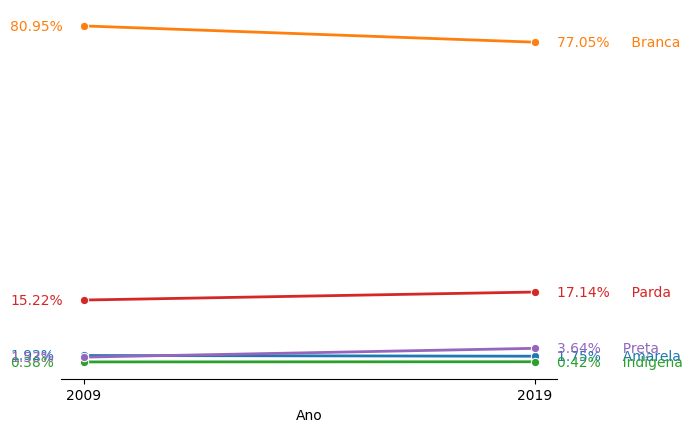

In [40]:
plot_slope_graph(x='Ano', hue="Raça", y="Porcentagem", data=count_by_deficiency_and_year)

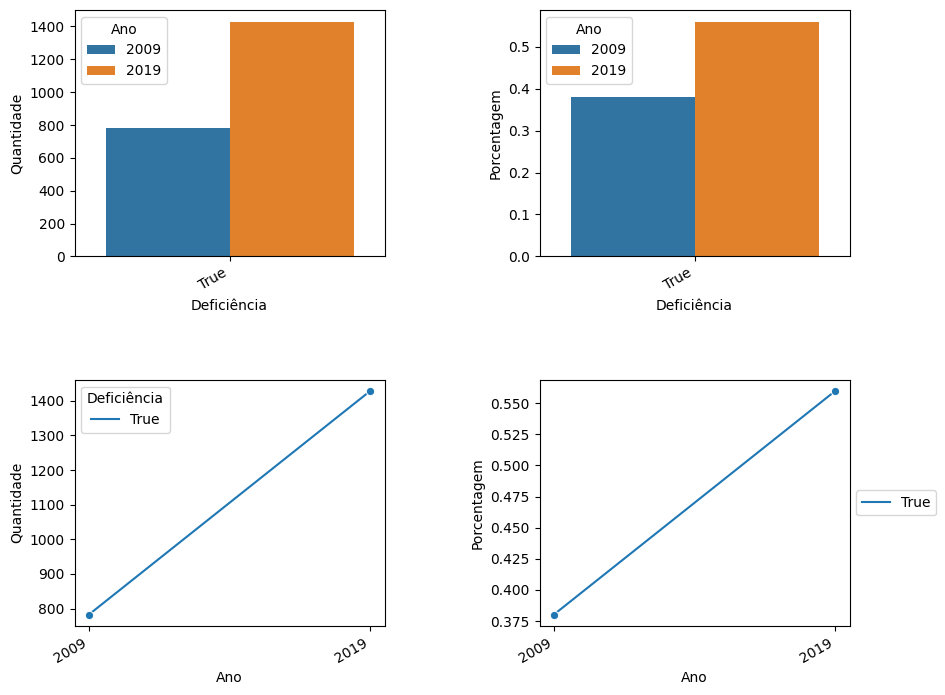

,Ano,Deficiência,Quantidade,Porcentagem
1,2009,True,782,0.38
3,2019,True,1429,0.56


In [41]:
teachers_by_deficiency, teachers_evolution_by_deficiency, count_by_deficiency_and_year = create_table_by_segregators(analysis_df, segregators=['Deficiência'])
plot_comparison_graph(count_by_deficiency_and_year[(count_by_deficiency_and_year['Deficiência'] == True)], segregator='Deficiência', label_rotation=30, horizontalalignment='right')

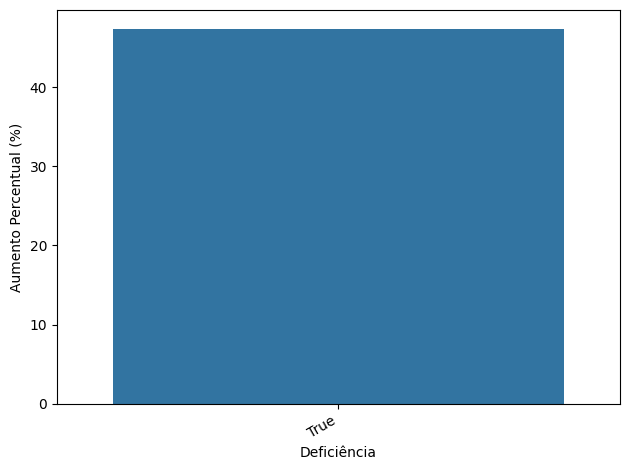

In [42]:
plot_evolution_graph(teachers_evolution_by_deficiency[teachers_evolution_by_deficiency['Deficiência'] == True], segregator='Deficiência', label_rotation = 30, horizontalalignment='right')